# INTRODUCTION TO DATA SCIENCE - PROJECT 3#
## Rishiraj Rana##
## Yearly Data Forecasting##

Data pre processing

In [ ]:
!pip install prophet

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import plotly.express as px
from prophet.plot import plot_plotly, plot_components_plotly
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import sys
import os
from tqdm.keras import TqdmCallback
from sklearn.model_selection import train_test_split
import json
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from prophet import Prophet
yearly_data = pd.read_csv('/content/SN_y_tot_V2.0.csv')
yearly_data.info()
yearly_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321 entries, 0 to 320
Data columns (total 1 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   1700.5;   8.3; -1.0;    -1;1  321 non-null    object
dtypes: object(1)
memory usage: 2.6+ KB


,1700.5; 8.3; -1.0; -1;1
0,1701.5; 18.3; -1.0; -1;1
1,1702.5; 26.7; -1.0; -1;1
2,1703.5; 38.3; -1.0; -1;1
3,1704.5; 60.0; -1.0; -1;1
4,1705.5; 96.7; -1.0; -1;1


In [ ]:
columns = [ 'Fractional Year', 'Sunspots', 'Std Dev', 'Observations', 'Definitive']
daily_data = pd.read_csv("/content/SN_y_tot_V2.0.csv", sep=";", header=None, names=columns)
daily_data.head()

,Fractional Year,Sunspots,Std Dev,Observations,Definitive
0,1700.5,8.3,-1.0,-1,1
1,1701.5,18.3,-1.0,-1,1
2,1702.5,26.7,-1.0,-1,1
3,1703.5,38.3,-1.0,-1,1
4,1704.5,60.0,-1.0,-1,1


In [ ]:
yearly_data = pd.read_csv('/content/SN_y_tot_V2.0.csv', sep=";", header=None, names=['Year', 'Sunspots', 'Std Dev', 'Observations', 'Definitive'])

yearly_data["Year"] = yearly_data["Year"].astype(float)
yearly_data["Integer Year"] = yearly_data["Year"].astype(int)
yearly_data["Fraction"] = yearly_data["Year"] - yearly_data["Integer Year"]
yearly_data["Date"] = pd.to_datetime(yearly_data["Integer Year"].astype(str) + "-01-01")

from datetime import timedelta
yearly_data["Date"] += yearly_data["Fraction"].apply(lambda x: timedelta(days=int(x * 365)))

In [ ]:
yearly_data.head()

,Year,Sunspots,Std Dev,Observations,Definitive,Integer Year,Fraction,Date
0,1700.5,8.3,-1.0,-1,1,1700,0.5,1700-07-02
1,1701.5,18.3,-1.0,-1,1,1701,0.5,1701-07-02
2,1702.5,26.7,-1.0,-1,1,1702,0.5,1702-07-02
3,1703.5,38.3,-1.0,-1,1,1703,0.5,1703-07-02
4,1704.5,60.0,-1.0,-1,1,1704,0.5,1704-07-01


In [ ]:
yearly_data = yearly_data[['Date', 'Sunspots']]
yearly_data.head()

,Date,Sunspots
0,1700-07-02,8.3
1,1701-07-02,18.3
2,1702-07-02,26.7
3,1703-07-02,38.3
4,1704-07-01,60.0


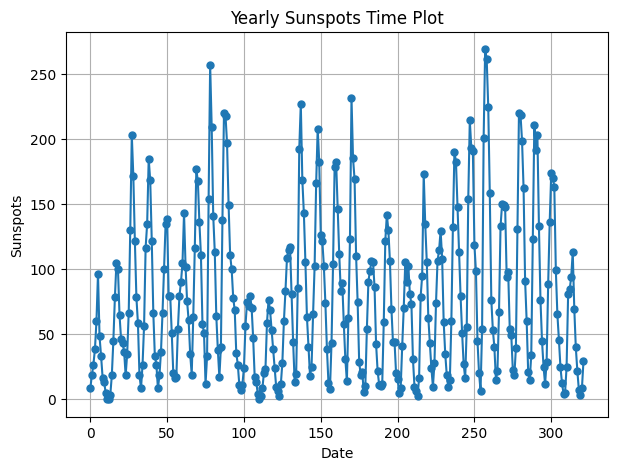

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(daily_data.index, daily_data['Sunspots'], marker='o', linestyle='-', markersize=5)
plt.xlabel('Date')
plt.ylabel('Sunspots')
plt.title('Yearly Sunspots Time Plot')
plt.grid(True)
plt.show()

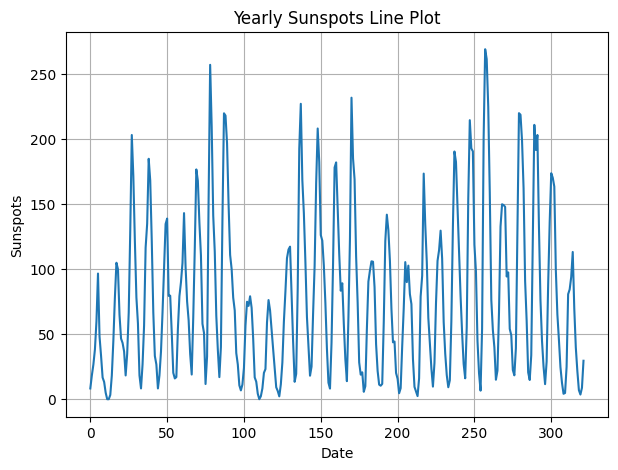

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))

plt.plot(daily_data.index, daily_data['Sunspots'])
plt.xlabel('Date')
plt.ylabel('Sunspots')
plt.title('Yearly Sunspots Line Plot')
plt.grid(True)
plt.show()

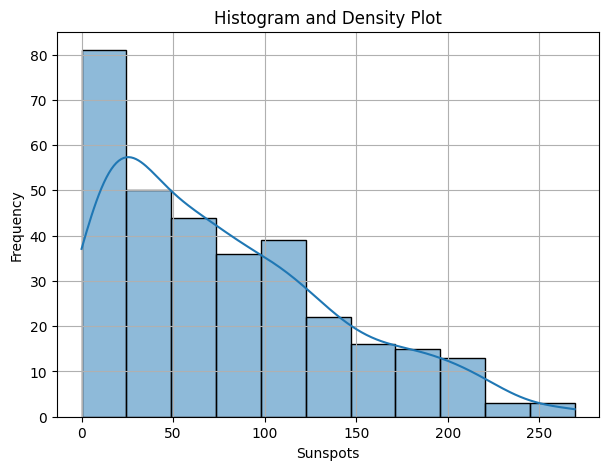

In [ ]:
# Histogram and Density Plot
plt.figure(figsize=(7, 5))
sns.histplot(daily_data['Sunspots'], kde=True)
plt.xlabel('Sunspots')
plt.ylabel('Frequency')
plt.title('Histogram and Density Plot')
plt.grid(True)
plt.show()

In [ ]:
yearly_data.columns

Index(['Date', 'Sunspots'], dtype='object')

In [ ]:
yearly_data = yearly_data.rename(columns={'Sunspots': 'y'})
yearly_data['ds'] = yearly_data.index
yearly_data.tail()

,Date,y,ds
317,2017-07-02,21.7,317
318,2018-07-02,7.0,318
319,2019-07-02,3.6,319
320,2020-07-01,8.8,320
321,2021-07-02,29.6,321


In [ ]:
if 'ds' in yearly_data.columns:
    yearly_data = yearly_data.drop(columns=['ds'])
else:
    print("Column 'ds' not found in DataFrame.")

yearly_data.head()

,Date,y
0,1700-07-02,8.3
1,1701-07-02,18.3
2,1702-07-02,26.7
3,1703-07-02,38.3
4,1704-07-01,60.0


In [ ]:
yearly_data = yearly_data.rename(columns={'Date': 'ds'})
yearly_data.head()


,ds,y
0,1700-07-02,8.3
1,1701-07-02,18.3
2,1702-07-02,26.7
3,1703-07-02,38.3
4,1704-07-01,60.0


In [ ]:
yearly_data['ds'] = pd.to_datetime(yearly_data['ds']).dt.floor('D')

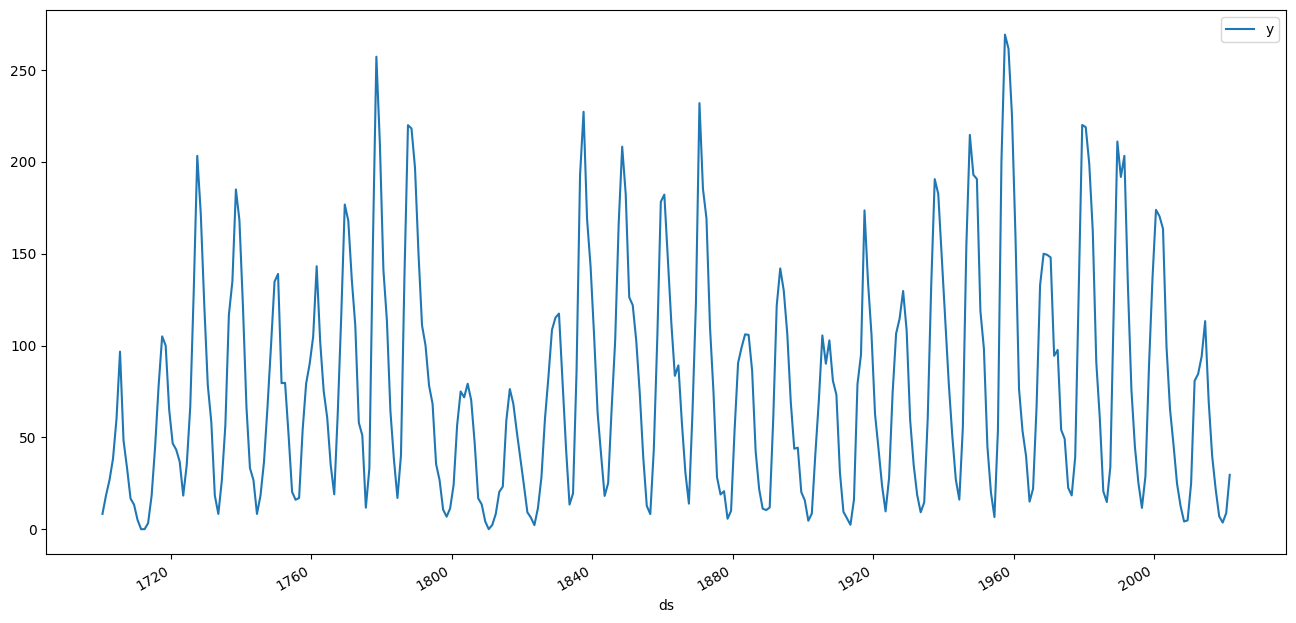

In [ ]:
yearly_data.plot(x='ds', y='y', figsize=(16,8))
plt.show()

Training the FBProphet model


In [ ]:
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric

In [ ]:
train = daily_data.iloc[:int(len(daily_data)*0.8)]
test = daily_data.iloc[int(len(daily_data)*0.8):]

In [ ]:
yearly_data['ds'] = pd.to_datetime(yearly_data['ds'], format='%Y-%m-%d').dt.floor('us')

yearly_data['ds_numeric'] = (yearly_data['ds'] - pd.Timestamp('1970-01-01')) // pd.Timedelta('1D')

In [ ]:
model = Prophet(growth='flat', yearly_seasonality=True)
model.add_seasonality(name='custom_yearly', period=11, fourier_order=5)
model.fit(yearly_data)

OutOfBoundsDatetime: Result is too large for pandas.Timedelta. Convert inputs to datetime.datetime with 'Timestamp.to_pydatetime()' before subtracting.

Making Predictions

In [1]:
future = model.make_future_dataframe(periods=20, freq='Y')
forecast = model.predict(future)

NameError: name 'model' is not defined

In [ ]:
forecast.tail()

In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
test.tail()

Plotting the forecast

In [ ]:
plot_plotly(model, forecast)

In [ ]:
future_1yr = model.make_future_dataframe(periods=1, freq='Y')
future_10yr = model.make_future_dataframe(periods=10, freq='Y')
future_20yr = model.make_future_dataframe(periods=20, freq='Y')

forecast_1yr = model.predict(future_1yr)
forecast_10yr = model.predict(future_10yr)
forecast_20yr = model.predict(future_20yr)

In [ ]:
plot_plotly(model, forecast_1yr)
print("1-year forecast:")
print(forecast_1yr[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

In [ ]:
plot_plotly(model, forecast_10yr)
print("\n10-year forecast:")
print(forecast_10yr[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

In [ ]:
plot_plotly(model, forecast_20yr)
print("\n20-year forecast:")
print(forecast_20yr[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

In [ ]:
plot_components_plotly(model, forecast)

Evolution

In [ ]:
from statsmodels.tools.eval_measures import rmse

In [ ]:
forecast_aligned = forecast[forecast['ds'].isin(test['ds'])]

min_len = min(len(test['y']), len(forecast_aligned['yhat']))
rmse_value = rmse(test['y'][:min_len], forecast_aligned['yhat'][:min_len])

print(rmse_value)

In [ ]:
forecast_aligned = forecast[forecast['ds'].isin(test['ds'])]

min_len = min(len(test['y']), len(forecast_aligned['yhat']))

predictions = forecast_aligned['yhat'][:min_len]

rmse_value = rmse(predictions, test['y'][:min_len])

print("Root mean squared error between actual and predicted values:", rmse_value)

print("mean value of the dataset: ",  test['y'].mean())

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
y_true = daily_data["y"][-365:]
y_pred = forecast["yhat"][-365:]
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Absolute Percentage Error:", mape)
print("R-squared:", r2)